# Experiments with Hough transform

Hough transform that operates in $(k, b)$ parameter space is needed. Rectangular images are supposed to be zero-padded in the direction of smaller dimension, as it is suggested by [Brady, M.L., 1998].

In [1]:
# Necessary includes

# Scikit-image (for image storing)
from skimage import io
from skimage import color
from skimage import filters
from skimage import draw
from skimage import transform
from skimage import measure
# NumPy (for fast vectorised computations)
import numpy as np
# Matplotlib (for inline image rendering)
import matplotlib.pyplot as plot
# Math (for trigonometry)
from math import cos, sin

In [2]:
# Experimental placeholder IM_PATH
#
# Needs to be replaced with a varibale set by end user
# in production version of the program

#IM_PATH = '../sample_images/NotreDamedeReims.jpg'
IM_PATH = '../sample_images/Moscow.jpg'

## Auxiliary toolset

In [3]:
def render_image(image, grayscale=False):
    plot.figure(figsize=(10, 10))
    if grayscale:
        plot.imshow(image, cmap=plot.cm.gray)
    else:
        plot.imshow(image)
    return

In [4]:
def add_padding(image, left=1, right=1, top=1, bottom=1, filler='#000000'):
    """
    Add padding to the image
    
    Parameters
    ----------
    image  : NumPy array
             Scikit-image image.
    left   : int
             Number of padded pixels from the left.
    right  : int
             Number of padded pixels from the right.
    top    : int
             Number of padded pixels from the top.
    bottom : int
             Number of padded pixels from the bottom.
    filler : string ('plume' or RGB colour as a 6-digit hex code)
             If 'plume', the padding will be filled with colours of the
             nearest border which will be linearly interpolated at corners.
             Otherwise, it will be filled with the specified colour.
    
    Padding is filled with <filler> colour.
    
    Returns
    -------
    padded_image : NumPy array
                   Scikit-image image with padding.
    """
    # 1. Create a billet for the padded image
    if filler == 'plume':
        padded_image = np.zeros((top + image.shape[0] + bottom, left + image.shape[1] + right, image.shape[2]), dtype='int')
        padded_image[top:top+image.shape[0], left:left+image.shape[1], :] = image
        # Fill left, right, top and bottom stripes
        for _ in range(top):
            padded_image[_, left:left+image.shape[1], :] = padded_image[top, left:left+image.shape[1], :]
        for _ in range(top+image.shape[0], padded_image.shape[0]):
            padded_image[_, left:left+image.shape[1], :] = padded_image[top+image.shape[0]-1, left:left+image.shape[1], :]
        for _ in range(left):
            padded_image[top:top+image.shape[0], _, :] = padded_image[top:top+image.shape[0], left, :]
        for _ in range(left+image.shape[1], padded_image.shape[1]):
            padded_image[top:top+image.shape[0], _, :] = padded_image[top:top+image.shape[0], left+image.shape[1]-1, :]
        # Fill corners
        
    return padded_image

## Step 1. Image load

We'll utilise Scikit-image.

In [5]:
image = io.imread(IM_PATH)

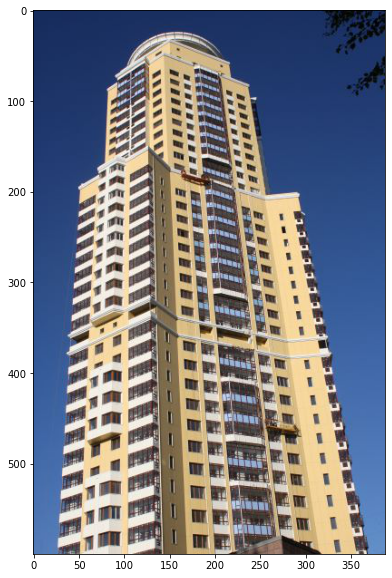

In [6]:
render_image(image)

## Step 2. Edge detection

With $3 \times 3$ Scharr operator.

In [7]:
edges = filters.scharr(filters.gaussian(color.rgb2gray(image), sigma=1))
edges[np.where(edges > filters.threshold_otsu(edges))] = 1
edges[np.where(edges != 1)] = 0
edges = edges.astype('int')

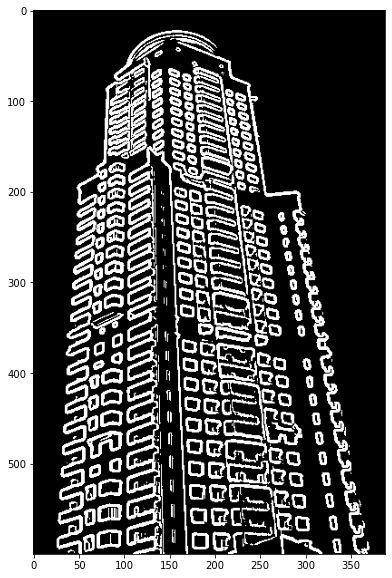

In [8]:
render_image(edges, grayscale=True)

## Step 3. Apply Hough

Hough transform is aimed at straight line detection. We represent lines in their classical parametrisation:

* $k$ is a slope;
* $b$ is an intercept.

In order to avoid infinitely large values of $k$ we distinguish between "predominantly vertical" and "predominantly horizontal" lines. Thus, the absolute values of $k$ never exceed one.

Mind the unusual coordinate system that is used here in images: the $x$ axis goes from the top left corner down to the bottom left corner; the $y$ axis goes from the top left corner to the top right corner. Hence, **predominantly horizontal** lines are expressed as

$$x = ky + b$$

and **predominantly vertical**, respectively, are represented as

$$y = kx + b$$

In [9]:
def hough_kb(image, verbose=False):
    # 1. Initialise horizontal Hough space
    hough_h = np.zeros((2 * image.shape[1] + 1, image.shape[0] + 2 * image.shape[1]), dtype='int')
    k_step_h = 2 / (hough_h.shape[0] - 1)
    k_h = np.arange(hough_h.shape[0])
    k_true_h = np.arange(-1.0, 1.0 + k_step_h, k_step_h)
    # 2. Initialise vertical Hough space
    hough_v = np.zeros((2 * image.shape[0] + 1, 2 * image.shape[0] + image.shape[1]), dtype='int')
    k_step_v = 2 / (hough_v.shape[0] - 1)
    k_v = np.arange(hough_v.shape[0])
    k_true_v = np.arange(-1.0, 1.0 + k_step_v, k_step_v)
    # 3. Saturate Hough spaces
    for point in np.array(np.where(image != 0)).T:
        if verbose:
            print(point)
        b = (point[0] - k_true_h * point[1] + image.shape[1]).astype('int')
        hough_h[k_h, b] += image[point[0]][point[1]]
        b = (point[1] - k_true_v * point[0] + image.shape[0]).astype('int')
        hough_v[k_v, b] += image[point[0]][point[1]]
    return hough_h, hough_v

In [10]:
hough_h, hough_v = hough_kb(edges)

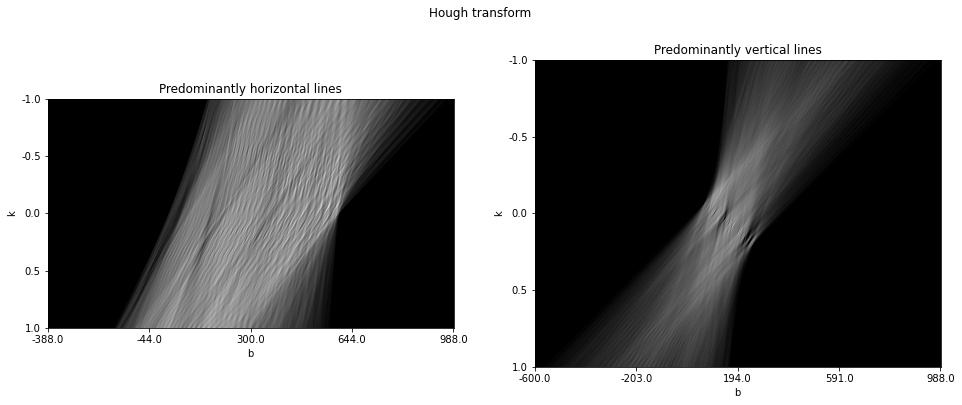

In [11]:
plot.figure(figsize=(16, 6))
plot.suptitle('Hough transform')

ax_h = plot.subplot(1, 2, 1)
ax_h.set_title('Predominantly horizontal lines')
ax_h.set_xticks(np.linspace(0, hough_h.shape[1] - 1, 5))
ax_h.set_xticklabels(np.linspace(-image.shape[1], image.shape[0] + image.shape[1], 5))
ax_h.set_yticks(np.linspace(0, hough_h.shape[0] - 1, 5))
ax_h.set_yticklabels(np.linspace(-1, 1, 5))
ax_h.set_xlabel('b')
ax_h.set_ylabel('k')
ax_h.imshow(hough_h / np.max(hough_h), cmap=plot.cm.gray);

ax_v = plot.subplot(1, 2, 2)
ax_v.set_title('Predominantly vertical lines')
ax_v.set_xticks(np.linspace(0, hough_v.shape[1] - 1, 5))
ax_v.set_xticklabels(np.linspace(-image.shape[0], image.shape[0] + image.shape[1], 5))
ax_v.set_yticks(np.linspace(0, hough_v.shape[0] - 1, 5))
ax_v.set_yticklabels(np.linspace(-1, 1, 5))
ax_v.set_xlabel('b')
ax_v.set_ylabel('k')
ax_v.imshow(hough_v / np.max(hough_v), cmap=plot.cm.gray);

## Step 4. Threshold Hough

We only need two intersecting vertical lines and two intersecting horizontal lines. We assume that a lot of lines in the building are supposed to be parallel.

In [12]:
def hough_kb_peaks(hough_space):
    # 1. We don't want to spoil the original Hough space
    hough_copy = hough_space.copy()
    # 2. Get rid of non-peak values
    #hough_copy = exposure.adjust_gamma(hough_copy, gamma=1.3)
    hough_copy[hough_copy < np.max(hough_copy) - 1.0 * np.std(hough_copy)] = 0
    #hough_copy[hough_copy < np.max(hough_copy) / 2] = 0
    #for peak_i in range(top_count):
        #k, b = np.unravel_index(np.argmax(hough_copy), hough_copy.shape)
        #k = -1 + k * 2 / (hough_copy.shape[0] - 1)
        #print(k, b, np.max(hough_copy))
    return hough_copy

In [13]:
peaks_h = hough_kb_peaks(hough_h)
peaks_v = hough_kb_peaks(hough_v)

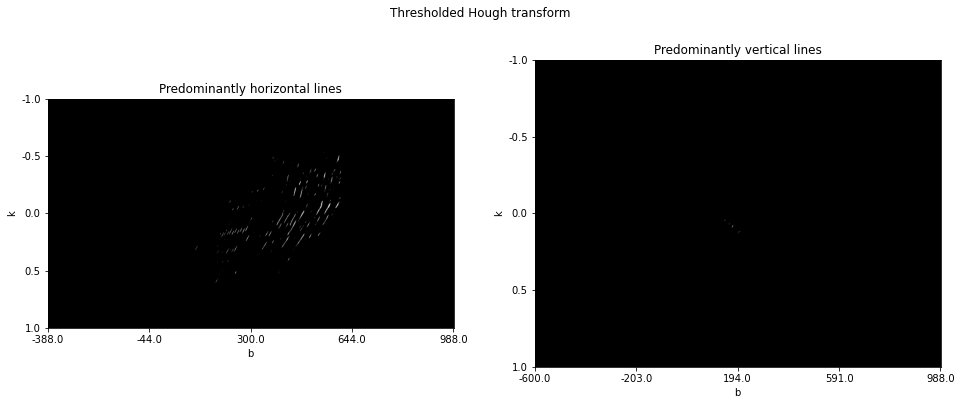

In [14]:
plot.figure(figsize=(16, 6))
plot.suptitle('Thresholded Hough transform')

ax_h = plot.subplot(1, 2, 1)
ax_h.set_title('Predominantly horizontal lines')
ax_h.set_xticks(np.linspace(0, hough_h.shape[1] - 1, 5))
ax_h.set_xticklabels(np.linspace(-image.shape[1], image.shape[0] + image.shape[1], 5))
ax_h.set_yticks(np.linspace(0, hough_h.shape[0] - 1, 5))
ax_h.set_yticklabels(np.linspace(-1, 1, 5))
ax_h.set_xlabel('b')
ax_h.set_ylabel('k')
ax_h.imshow(peaks_h / np.max(peaks_h), cmap=plot.cm.gray);

ax_v = plot.subplot(1, 2, 2)
ax_v.set_title('Predominantly vertical lines')
ax_v.set_xticks(np.linspace(0, hough_v.shape[1] - 1, 5))
ax_v.set_xticklabels(np.linspace(-image.shape[0], image.shape[0] + image.shape[1], 5))
ax_v.set_yticks(np.linspace(0, hough_v.shape[0] - 1, 5))
ax_v.set_yticklabels(np.linspace(-1, 1, 5))
ax_v.set_xlabel('b')
ax_v.set_ylabel('k')
ax_v.imshow(peaks_v / np.max(peaks_v), cmap=plot.cm.gray);

## Step 5. Identify clusters in Hough spaces

In [15]:
def clusterise(image):
    answer = np.zeros(image.shape)
    # 1. Create binary mask of non-zero pixels
    image_bin = image.copy()
    image_bin[image_bin != 0] = 1
    # 2. Form a list of connected regions
    labels, labels_count = measure.label(image_bin, background=0, return_num=True)
    clusters = tuple(np.where(labels == label) for label in range(1, labels_count + 1))
    # 3. Replace each cluster with a single representative
    for cluster in clusters:
        cluster_centre = (np.mean(cluster[0]).astype('int'), np.mean(cluster[1]).astype('int'))
        answer[cluster_centre[0]][cluster_centre[1]] = np.sum(image[cluster])
    return answer.astype('int')

In [16]:
clusters_h = clusterise(peaks_h)
clusters_v = clusterise(peaks_v)

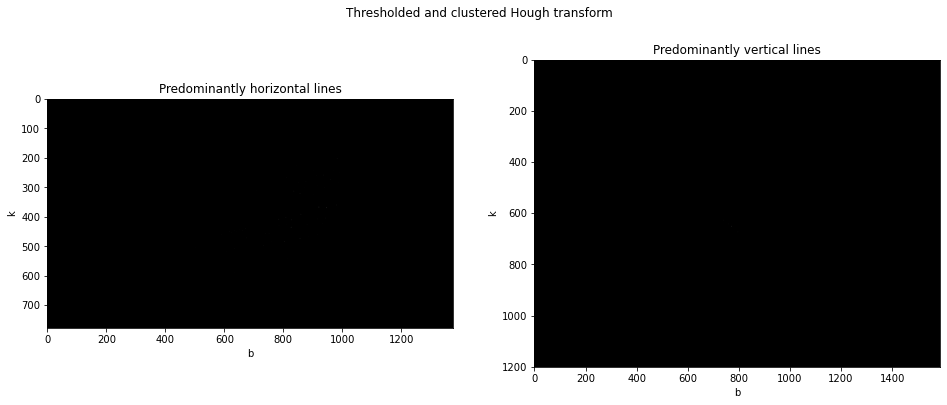

In [17]:
plot.figure(figsize=(16, 6))
plot.suptitle('Thresholded and clustered Hough transform')

ax_h = plot.subplot(1, 2, 1)
ax_h.set_title('Predominantly horizontal lines')
#ax_h.set_xticks(np.linspace(0, clusters_h.shape[1] - 1, 5))
#ax_h.set_xticklabels(np.linspace(-image.shape[1], image.shape[0] + image.shape[1], 5))
#ax_h.set_yticks(np.linspace(0, clusters_h.shape[0] - 1, 5))
#ax_h.set_yticklabels(np.linspace(-1, 1, 5))
ax_h.set_xlabel('b')
ax_h.set_ylabel('k')
ax_h.imshow(clusters_h / np.max(clusters_h), cmap=plot.cm.gray);

ax_v = plot.subplot(1, 2, 2)
ax_v.set_title('Predominantly vertical lines')
#ax_v.set_xticks(np.linspace(0, clusters_v.shape[1] - 1, 5))
#ax_v.set_xticklabels(np.linspace(-image.shape[0], image.shape[0] + image.shape[1], 5))
#ax_v.set_yticks(np.linspace(0, clusters_v.shape[0] - 1, 5))
#ax_v.set_yticklabels(np.linspace(-1, 1, 5))
ax_v.set_xlabel('b')
ax_v.set_ylabel('k')
ax_v.imshow(clusters_v / np.max(clusters_v), cmap=plot.cm.gray);

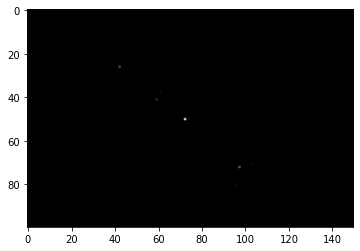

In [18]:
plot.imshow(clusters_v[600:700, 700:850] / np.max(clusters_v), cmap=plot.cm.gray);

## Step 5. Apply Hough for Hough

We consider Hough Hough spaces to discover vertical and horizontal vanishing points.

In [19]:
hough_h_hough_h, hough_h_hough_v = hough_kb(clusters_h)

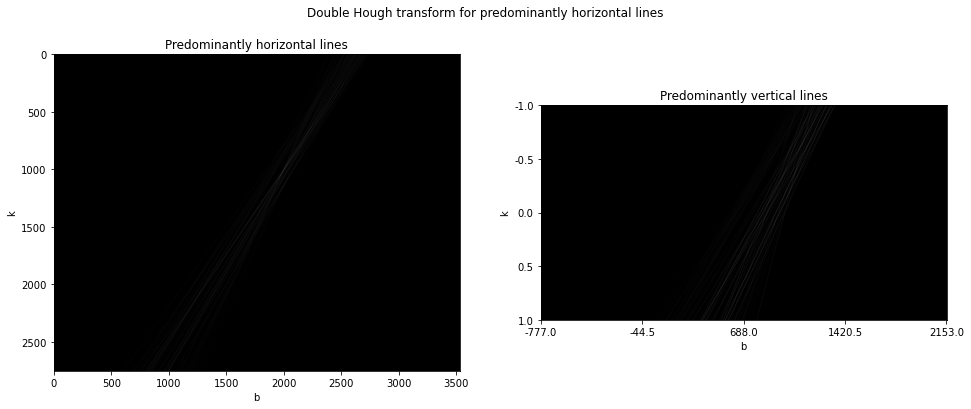

In [20]:
plot.figure(figsize=(16, 6))
plot.suptitle('Double Hough transform for predominantly horizontal lines')

ax_h = plot.subplot(1, 2, 1)
ax_h.set_title('Predominantly horizontal lines')
#ax_h.set_xticks(np.linspace(0, hough_h_hough_h.shape[1] - 1, 5))
#ax_h.set_xticklabels(np.linspace(-hough_h.shape[1], hough_h.shape[0] + hough_h.shape[1], 5))
#ax_h.set_yticks(np.linspace(0, hough_h_hough_h.shape[0] - 1, 5))
#ax_h.set_yticklabels(np.linspace(-1, 1, 5))
ax_h.set_xlabel('b')
ax_h.set_ylabel('k')
ax_h.imshow(hough_h_hough_h / np.max(hough_h_hough_h), cmap=plot.cm.gray);

ax_v = plot.subplot(1, 2, 2)
ax_v.set_title('Predominantly vertical lines')
ax_v.set_xticks(np.linspace(0, hough_h_hough_v.shape[1] - 1, 5))
ax_v.set_xticklabels(np.linspace(-hough_h.shape[0], hough_h.shape[0] + hough_h.shape[1], 5))
ax_v.set_yticks(np.linspace(0, hough_h_hough_v.shape[0] - 1, 5))
ax_v.set_yticklabels(np.linspace(-1, 1, 5))
ax_v.set_xlabel('b')
ax_v.set_ylabel('k')
ax_v.imshow(hough_h_hough_v / np.max(hough_h_hough_v), cmap=plot.cm.gray);

Let us discover the dominant line in horizontal Hough space. It will be associated with the dominant horizontal vanishing point (hopefully).

In [21]:
np.max(hough_h_hough_h), np.max(hough_h_hough_v)

(54936, 36392)

In [22]:
np.unravel_index(np.argmax(hough_h_hough_h), hough_h_hough_h.shape)

(1029, 1984)

In [23]:
k = -1 + 1029 * 2 / (hough_h_hough_h.shape[0] - 1)
b = 1984 - peaks_h.shape[1]
k, b

(-0.2521802325581395, 608)

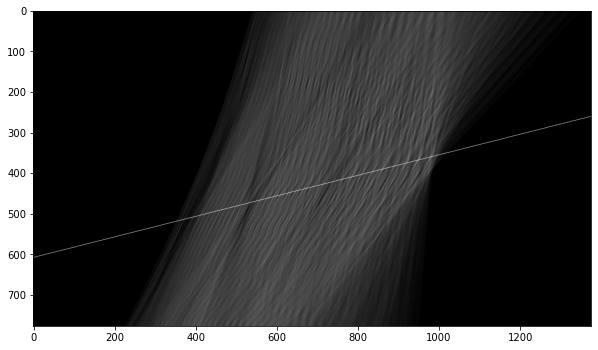

In [24]:
hough_h_ = hough_h.copy()

c0 = 0
c1 = hough_h_.shape[1] - 1
r0 = int(k * c0 + b)
r1 = int(k * c1 + b)
rr, cc = draw.line(r0, c0, r1, c1)

hough_h_[rr, cc] = 2 * np.max(hough_h_)

render_image(hough_h_, grayscale=True)

In [25]:
r0 = int(hough_h_.shape[0] / 2)
r1 = hough_h_.shape[0] - 1
c0 = int(k * r0 + b)
c1 = int(k * r1 + b)

x = c0 - image.shape[1]
y = x - c1 - image.shape[1]

print('Dominant horizontal vanishing point:', x, y)

Dominant horizontal vanishing point: 122 -678


In [26]:
hough_v_hough_h, hough_v_hough_v = hough_kb(clusters_v)

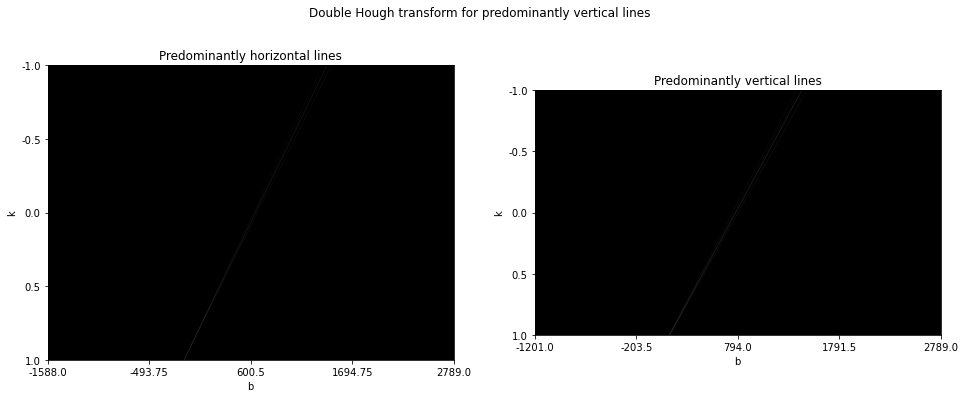

In [27]:
plot.figure(figsize=(16, 6))
plot.suptitle('Double Hough transform for predominantly vertical lines')

ax_h = plot.subplot(1, 2, 1)
ax_h.set_title('Predominantly horizontal lines')
ax_h.set_xticks(np.linspace(0, hough_v_hough_h.shape[1] - 1, 5))
ax_h.set_xticklabels(np.linspace(-hough_v.shape[1], hough_v.shape[0] + hough_v.shape[1], 5))
ax_h.set_yticks(np.linspace(0, hough_v_hough_h.shape[0] - 1, 5))
ax_h.set_yticklabels(np.linspace(-1, 1, 5))
ax_h.set_xlabel('b')
ax_h.set_ylabel('k')
ax_h.imshow(hough_v_hough_h / np.max(hough_v_hough_h), cmap=plot.cm.gray);

ax_v = plot.subplot(1, 2, 2)
ax_v.set_title('Predominantly vertical lines')
ax_v.set_xticks(np.linspace(0, hough_v_hough_v.shape[1] - 1, 5))
ax_v.set_xticklabels(np.linspace(-hough_v.shape[0], hough_v.shape[0] + hough_v.shape[1], 5))
ax_v.set_yticks(np.linspace(0, hough_v_hough_v.shape[0] - 1, 5))
ax_v.set_yticklabels(np.linspace(-1, 1, 5))
ax_v.set_xlabel('b')
ax_v.set_ylabel('k')
ax_v.imshow(hough_v_hough_v / np.max(hough_v_hough_v), cmap=plot.cm.gray);

In [28]:
np.max(hough_v_hough_h), np.max(hough_v_hough_v)

(8712, 6649)

In [29]:
np.unravel_index(np.argmax(hough_v_hough_h), hough_v_hough_h.shape)

(2925, 1588)

In [30]:
k = -1 + 2925 * 2 / (hough_v_hough_h.shape[0] - 1)
b = 1588 - peaks_v.shape[1]
k, b

(0.8419395465994963, 0)

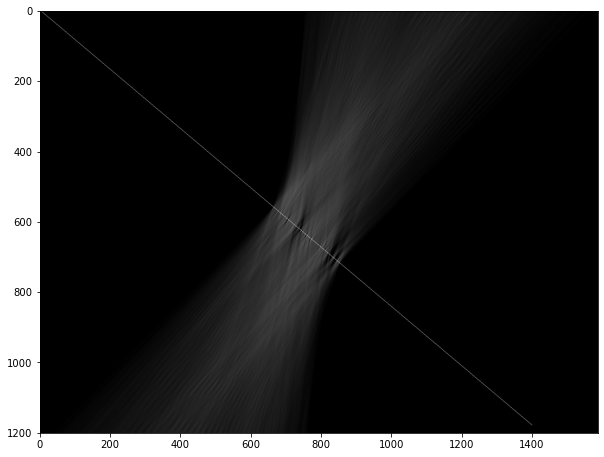

In [31]:
hough_v_ = hough_v.copy()

c0 = 0
c1 = 1400
r0 = int(k * c0 + b)
r1 = int(k * c1 + b)
rr, cc = draw.line(r0, c0, r1, c1)

hough_v_[rr, cc] = 2 * np.max(hough_v_)

render_image(hough_v_, grayscale=True)

In [32]:
r0 = int(hough_v_.shape[0] / 2)
r1 = hough_v_.shape[0] - 1
c0 = int(k * r0 + b)
c1 = int(k * r1 + b)

y = c0 - image.shape[1]
x = y - c1 - image.shape[1]

print('Dominant vertical vanishing point:', x, y)

Dominant vertical vanishing point: -1281 117
